In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
#Loading training dataset 
df = pd.read_csv('./data/liar-fake-news-dataset/train.tsv', sep='\t')
df.head()


,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [5]:
df.describe()

,0,1,0.1,0.2,0.3
count,10237.000000,10237.000000,10237.000000,10237.000000,10237.000000
mean,11.534336,13.287682,17.135391,16.435870,6.202012
std,18.974349,24.113808,35.847862,36.153089,16.129599
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [6]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   2635.json                                                                           10239 non-null  object 
 1   false                                                                               10239 non-null  object 
 2   Says the Annies List political group supports third-trimester abortions on demand.  10239 non-null  object 
 3   abortion                                                                            10237 non-null  object 
 4   dwayne-bohac                                                                        10237 non-null  object 
 5   State representative                                                                7341 non-nu

In [7]:
#Dropping NaN values
df.dropna(inplace=True)  # Or df.fillna('Unknown', inplace=True)


In [8]:
#Adding headers for columns 
column_headers = [
    'id', 'label', 'statement', 'subjects', 'speaker', 'speaker_job',
    'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
    'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'
]

df = pd.read_csv('./data/liar-fake-news-dataset/test.tsv', delimiter='\t', names=column_headers, header=None)


In [9]:
import spacy
import re

# Load SpaCy's English-language model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    #replacing non-word characters with a space (special characters etc...)
    text = re.sub(r'\W', ' ', str(text))

    #converting all characters to lower case for uniformity
    text = text.lower()

    #removing single characters
    text = re.sub(r'\s+[a-z]\s+', ' ', text)

    #removing single characters from the start of the text 
    text = re.sub(r'^[a-z]\s+', ' ', text)

    #reducing multiple spaces to 1 single space
    text = re.sub(r'\s+', ' ', text)
    
    #Parcing the text
    doc = nlp(text)
    
    #tokenizing text into words
    processed_text = ' '.join(token.lemma_ for token in doc if not token.is_stop and not token.is_space)
    return processed_text

#Applying the preprocess function to the "Statement" column
df['cleaned_text'] = df['statement'].apply(preprocess_text)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1267 non-null   object
 1   label                 1267 non-null   object
 2   statement             1267 non-null   object
 3   subjects              1267 non-null   object
 4   speaker               1267 non-null   object
 5   speaker_job           942 non-null    object
 6   state_info            1005 non-null   object
 7   party_affiliation     1267 non-null   object
 8   barely_true_counts    1267 non-null   int64 
 9   false_counts          1267 non-null   int64 
 10  half_true_counts      1267 non-null   int64 
 11  mostly_true_counts    1267 non-null   int64 
 12  pants_on_fire_counts  1267 non-null   int64 
 13  context               1250 non-null   object
 14  cleaned_text          1267 non-null   object
dtypes: int64(5), object(10)
memory usage: 

In [11]:
df.describe()


,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,11.770324,13.465667,17.566693,16.912391,6.016575
std,18.980496,23.956307,36.109290,36.499879,15.059981
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,1.000000
75%,12.000000,17.000000,15.000000,14.000000,6.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [12]:
df.shape

(1267, 15)

In [24]:
#Addt'l preprocessing steps 
#Expanding Contractions

import re

contractions_dict = {
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "let's": "let us",
    "mightn't": "might not",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where's": "where is",
    "who'd": "who would",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

contraction_pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')

def expand_contractions(text, contraction_mapping=contractions_dict):
    def replace(match):
        return contraction_mapping[match.group(0)]
    return contraction_pattern.sub(replace, text)

df['statement'] = df['statement'].apply(expand_contractions)
    

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_text'])

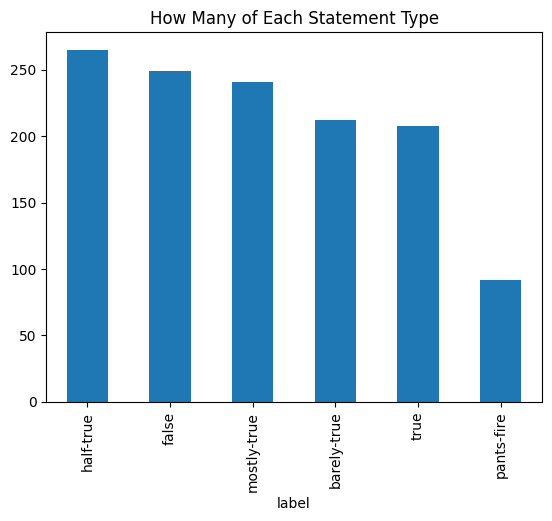

label
half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: count, dtype: int64


In [26]:
# Getting the class-distribution 
df['label'].value_counts().plot(kind='bar')
plt.title('How Many of Each Statement Type')
plt.show()

# Show the exact #s
class_counts = df['label'].value_counts()
print(class_counts)


In [27]:
# Encoding the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Initializing and applying SMOTE
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X, y)

# Check the new class distribution
print(pd.Series(y_balanced).value_counts())



5    265
1    265
2    265
4    265
0    265
3    265
Name: count, dtype: int64


In [28]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.37      0.47      0.42        55
           1       0.37      0.27      0.31        60
           2       0.18      0.16      0.17        56
           3       0.32      0.40      0.35        48
           4       0.65      0.82      0.73        40
           5       0.45      0.34      0.39        59

    accuracy                           0.39       318
   macro avg       0.39      0.41      0.39       318
weighted avg       0.38      0.39      0.38       318

